# Predicting graduation rates group project

In this group project, you'll be predicting graduation rates (or, more specifically, the percent difference from the mean graduation rate) for high school students in different areas of the country.

As you may already know, [your illustrious instructor Dave Yerrington won a competition on this dataset.](http://devpost.com/software/sriozidave_datafordiploma)

---

### Dataset

The files for this project can be found in the `/DSI-SF-2/datasets/data_for_diplomas/` folder. The contents are:

    grad_train: the training data you will be building models on
    graduation_with_census_schema.pdf: the "codebook" for the grad_train.csv columns
    school_county_spending.csv: data on the spending of different schools
    school_county_spending_info.pdf: information about the spending data csv
    climate_data/: a folder that has climate data for every state for 2011 and 2012. There are csvs for precipitation and average temperature
    
This isn't all the data Dave used, but it's a decent amount of it. You're not expected to use _all_ of this data. After all, you don't have that long to build these models, but it's there if you want to.

**Target variable:**

In the spreadsheet there is a variable called `grad_pct_from_mean`. This is the difference in percent graduated for that school from the mean graduation rate across the country. In other words, it is:

    (schools graduation rate / (mean of all schools graduation rate) - 1.) * 100.
    
I changed this from the original rate column because, as you know, regression is not appropriate for prediction of rates since they are guaranteed to fall between 0 and 1.

**Do not include variables in the model that contain the same information as the target variable!** 

---

### Structure of the project

You will, in groups, try to build a model that predicts this `grad_pct_from_mean` variable using the information you have. 

**This project is also an excercise in using your time wisely.** You don't have that much time, so keep the scope of your process simple rather than complex. This will likely mean _not_ considering every variable available to you.

**I have left out 25% of the data as a testing set. At the end, groups will come up and get to test their model on the testing set.**

Since you will likely be cleaning the data, you will need to be able to run the testing code through the same cleaning and munging process as the training data. I recommend writing some functions that make this process faster/easier!

Good luck!

In [987]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [988]:
grad_train = pd.read_csv('/Users/alex/Desktop/DSI-SF-2-akodate/datasets/data_for_diplomas/grad_train.csv')
spending = pd.read_csv('/Users/alex/Desktop/DSI-SF-2-akodate/datasets/data_for_diplomas/school_county_spending.csv')
climate = pd.read_csv('/Users/alex/Desktop/DSI-SF-2-akodate/datasets/data_for_diplomas/combined_climate_data.csv')

print grad_train.shape
print spending.shape
print climate.shape

(7338, 580)
(14482, 66)
(50, 5)


In [989]:
pd.options.display.max_rows = 600

In [990]:
def merge_df(spending):
    spending = spending[spending.NCESID.apply(lambda x: x.isdigit())]
    spending.NCESID = spending.NCESID.map(lambda x: int(x))
    return spending
    
spending_mergeable = merge_df(spending)

In [991]:
# spending_mergeable.head(2)

In [992]:
climate = climate.drop('Unnamed: 0', axis=1)

In [993]:
df_merged = grad_train.merge(spending_mergeable, left_on='leaid11', right_on='NCESID')
df_merged = df_merged.merge(climate, left_on='State_name', right_on='state_y')

In [994]:
# df_merged.head().T

In [995]:
# df_merged.isnull().sum()

In [996]:
# Percent not null in each column
percent_not_null = (grad_train.shape[0] - grad_train.isnull().sum()) / 7338.0 * 100
grad_dropped = df_merged.drop(df_merged[percent_not_null[percent_not_null < 99.5].index], axis=1)
# grad_dropped = df_merged.copy()

In [997]:
# grad_dropped.isnull().sum()

In [998]:
grad_dropped.shape

(7297, 387)

In [999]:
grad_dropped.columns = [col_name.lower().replace(' ', '_').replace('.', '_').replace('(', '').replace(')', '').replace('-', '_') for col_name in grad_dropped.columns]
# grad_dropped.dtypes

In [1000]:
import patsy
df = grad_dropped.copy()

all_columns = "" + " + ".join(df.columns.difference([
            'all_rate_1112', 
            'percentage', 
            'grad_pct_from_mean', 
            'tract', 
            'tract_code', 
            'leaid11', 
            'stnam', 
            'leanm11', 
            'ncesid',
            'district_id',
            'school_district', 
            'county_name', 
            'name',
            'conum',
            'csa',
            'cbsa',
            'state_name',
            'state_y',
            'state_1',
            'county_1',
            'idcensus',
            'county',
            'gidtr']))


# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12', 'pct_not_mrdcple_hhd_cen_2010','ecd_rate_1112', 'ppsalwg', 'ppisalwg'])
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12', 'pct_not_mrdcple_hhd_cen_2010', 'ppsalwg', 'ppisalwg'])
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12','ecd_rate_1112'])
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12'])
# all_columns = "" + " + ".join(['ppsalwg', 'ppisalwg'])
formula = "grad_pct_from_mean ~ " + all_columns + " - 1"
print formula

y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
print X.shape
print y.shape

grad_pct_from_mean ~ age5p_african_acs_08_12 + age5p_african_acsmoe_08_12 + age5p_arabic_acs_08_12 + age5p_arabic_acsmoe_08_12 + age5p_armenian_acs_08_12 + age5p_armenian_acsmoe_08_12 + age5p_cambodian_acs_08_12 + age5p_cambodian_acsmoe_08_12 + age5p_chinese_acs_08_12 + age5p_chinese_acsmoe_08_12 + age5p_frcreole_acs_08_12 + age5p_frcreole_acsmoe_08_12 + age5p_french_acs_08_12 + age5p_french_acsmoe_08_12 + age5p_german_acs_08_12 + age5p_german_acsmoe_08_12 + age5p_greek_acs_08_12 + age5p_greek_acsmoe_08_12 + age5p_gujarati_acs_08_12 + age5p_gujarati_acsmoe_08_12 + age5p_hebrew_acs_08_12 + age5p_hebrew_acsmoe_08_12 + age5p_hindi_acs_08_12 + age5p_hindi_acsmoe_08_12 + age5p_hmong_acs_08_12 + age5p_hmong_acsmoe_08_12 + age5p_hungarian_acs_08_12 + age5p_hungarian_acsmoe_08_12 + age5p_italian_acs_08_12 + age5p_italian_acsmoe_08_12 + age5p_japanese_acs_08_12 + age5p_japanese_acsmoe_08_12 + age5p_korean_acs_08_12 + age5p_korean_acsmoe_08_12 + age5p_laotian_acs_08_12 + age5p_laotian_acsmoe_08_

In [1001]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(5778, 364) (5778,)
(1445, 364) (1445,)


In [1002]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xn_train = ss.fit_transform(X_train)
Xn_test = ss.fit_transform(X_test)

In [1003]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

optimal_elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=500, cv=5, verbose=1, n_jobs=1)
model = optimal_elastic.fit(Xn_train, y_train)
# model = ElasticNet(alpha=optimal_elastic.alpha_, l1_ratio=optimal_elastic.l1_ratio_).fit(X_train, y_train)

print "Optimal alpha:", optimal_elastic.alpha_
print "Optimal L1 ratio:", optimal_elastic.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal alpha: 0.238253386364
Optimal L1 ratio: 0.7


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.2min finished


Model Score: 0.389315285743


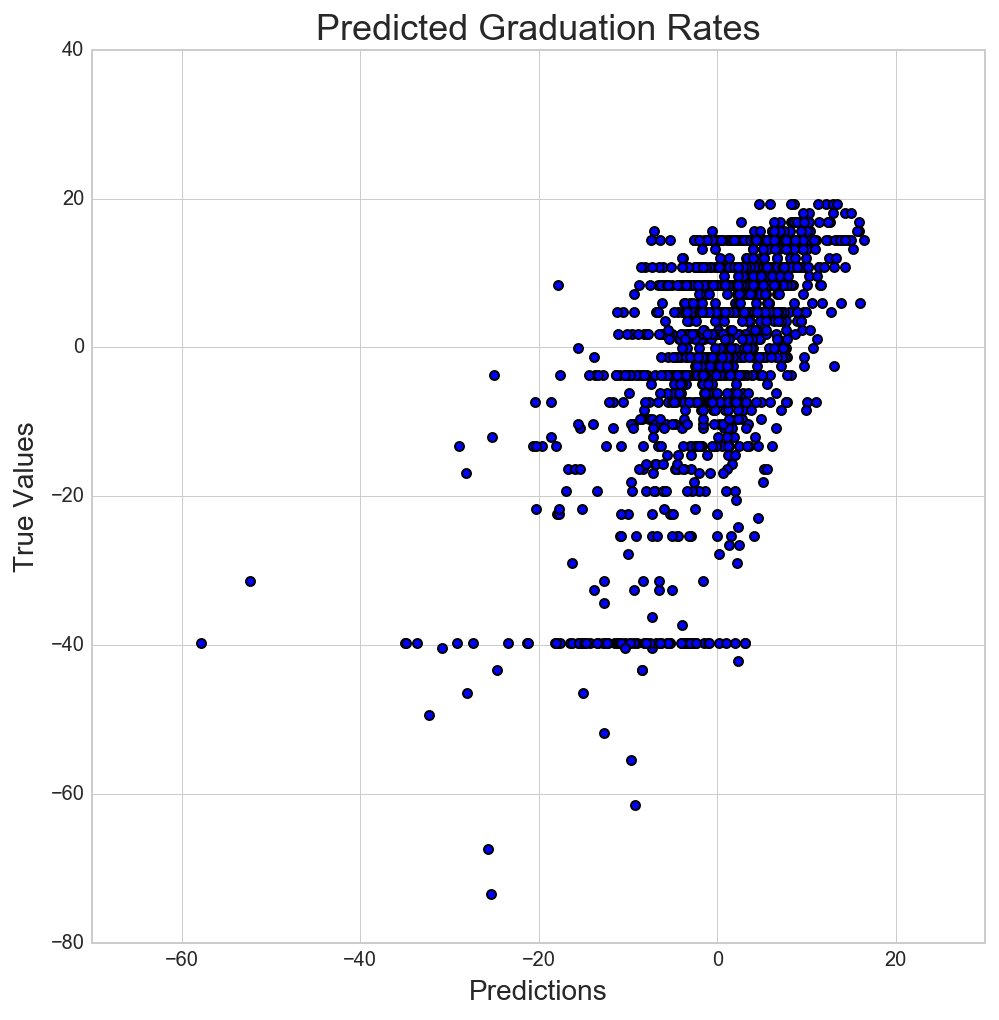

In [1004]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=[8,8])

plt.xlabel('Predictions', fontsize=14)
plt.ylabel('True Values', fontsize=14)
plt.title("Predicted Graduation Rates", fontsize=18)

predictions = model.predict(Xn_test)
score = model.score(Xn_test, y_test)

plt.scatter(predictions, y_test)
print 'Model Score:', score

In [1011]:
coeffs = pd.DataFrame(zip(model.coef_, X.columns)).sort_values(0)
coeffs.head(50)

,0,1
287,-4.157821,ppsgenad
246,-1.894357,pctfcomp
161,-1.258234,land_area
193,-0.942208,nh_blk_alone_acsmoe_08_12
241,-0.821223,pct_pop_under_5_cen_2010
181,-0.579713,mobile_homes_acs_08_12
281,-0.575632,ppcstot
315,-0.552859,strform
294,-0.519984,pub_asst_inc_acs_08_12
317,-0.501612,strspec


In [1012]:
coeffs.tail(50)

,0,1
107,0.000000,civ_labor_45_64_acs_08_12
153,-0.000000,hhd_moved_in_acsmoe_08_12
117,-0.000000,civ_unemp_45_64_acs_08_12
112,-0.000000,civ_unemp_16_24_acsmoe_08_12
113,-0.000000,civ_unemp_16plus_acs_08_12
114,0.000000,civ_unemp_16plus_acsmoe_08_12
116,0.000000,civ_unemp_25_44_acsmoe_08_12
115,-0.000000,civ_unemp_25_44_acs_08_12
168,0.000000,locrtax
166,-0.000000,locrpar


.


.


.


.


.


.


.


.


.


.


.


.

In [1013]:
grad_test = pd.read_csv('/Users/alex/Desktop/DSI-SF-2-akodate/datasets/data_for_diplomas/grad_test.csv')

In [1014]:
df_merged = grad_test.merge(spending_mergeable, how='left', left_on='leaid11', right_on='NCESID')
df_merged = df_merged.merge(climate, how='left', left_on='State_name', right_on='state_y')
df_merged.shape

(2447, 650)

In [1015]:
# df_merged.tail().T

In [1016]:
# df_merged.isnull().sum()

In [1017]:
# Percent not null in each column
# percent_not_null = (grad_test.shape[0] - grad_test.isnull().sum()) / float(grad_test.shape[0]) * 100
# grad_dropped = df_merged.drop(df_merged[percent_not_null[percent_not_null < 99].index], axis=1)
grad_dropped = df_merged.copy()

In [1018]:
grad_dropped.shape

(2447, 650)

In [1019]:
grad_dropped.columns = [col_name.lower().replace(' ', '_').replace('.', '_').replace('(', '').replace(')', '').replace('-', '_') for col_name in grad_dropped.columns]
# grad_dropped.dtypes

In [1020]:
import patsy
df = grad_dropped.copy()


# all_columns = "" + " + ".join(df.columns.difference([
#             'all_rate_1112', 
#             'percentage', 
#             'grad_pct_from_mean', 
#             'tract', 
#             'tract_code', 
#             'leaid11', 
#             'stnam', 
#             'leanm11', 
#             'school_district', 
#             'county_name', 
#             'name',
#             'conum',
#             'csa',
#             'cbsa',
#             'state_y',
#             'gidtr']))


# all_columns = "" + " + ".join(df.columns[:400].difference(['all_rate_1112', 'percentage', 'grad_pct_from_mean', 'tract', 'tract_code', 'leaid11', 'stnam', 'leanm11', 'school_district', 'county_name', 'gidtr']))
# all_columns = "" + " + ".join(df.columns[:450].difference(['all_rate_1112', 'grad_pct_from_mean', 'tract', 'tract_code', 'leaid11', 'stnam', 'leanm11', 'school_district', 'county_name', 'gidtr']))
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12', 'pct_not_mrdcple_hhd_cen_2010','ecd_rate_1112', 'ppsalwg', 'ppisalwg'])
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12', 'pct_not_mrdcple_hhd_cen_2010', 'ppsalwg', 'ppisalwg'])
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12','ecd_rate_1112'])
# all_columns = "" + " + ".join(['pct_prs_blw_pov_lev_acs_08_12','pct_not_mrdcple_hhd_acs_08_12'])
# all_columns = "" + " + ".join(['ppsalwg', 'ppisalwg'])
formula = "grad_pct_from_mean ~ " + all_columns + " - 1"
print formula

y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
print X.shape
print y.shape

grad_pct_from_mean ~ age5p_african_acs_08_12 + age5p_african_acsmoe_08_12 + age5p_arabic_acs_08_12 + age5p_arabic_acsmoe_08_12 + age5p_armenian_acs_08_12 + age5p_armenian_acsmoe_08_12 + age5p_cambodian_acs_08_12 + age5p_cambodian_acsmoe_08_12 + age5p_chinese_acs_08_12 + age5p_chinese_acsmoe_08_12 + age5p_frcreole_acs_08_12 + age5p_frcreole_acsmoe_08_12 + age5p_french_acs_08_12 + age5p_french_acsmoe_08_12 + age5p_german_acs_08_12 + age5p_german_acsmoe_08_12 + age5p_greek_acs_08_12 + age5p_greek_acsmoe_08_12 + age5p_gujarati_acs_08_12 + age5p_gujarati_acsmoe_08_12 + age5p_hebrew_acs_08_12 + age5p_hebrew_acsmoe_08_12 + age5p_hindi_acs_08_12 + age5p_hindi_acsmoe_08_12 + age5p_hmong_acs_08_12 + age5p_hmong_acsmoe_08_12 + age5p_hungarian_acs_08_12 + age5p_hungarian_acsmoe_08_12 + age5p_italian_acs_08_12 + age5p_italian_acsmoe_08_12 + age5p_japanese_acs_08_12 + age5p_japanese_acsmoe_08_12 + age5p_korean_acs_08_12 + age5p_korean_acsmoe_08_12 + age5p_laotian_acs_08_12 + age5p_laotian_acsmoe_08_

In [1021]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

y = np.ravel(y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

#print X_train.shape, y_train.shape
#print X_test.shape, y_test.shape

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

optimal_elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=500, cv=5, verbose=1, n_jobs=1)
model = optimal_elastic.fit(X_train, y_train)
# model = ElasticNet(alpha=optimal_elastic.alpha_, l1_ratio=optimal_elastic.l1_ratio_).fit(X_train, y_train)

print "Optimal alpha:", optimal_elastic.alpha_
print "Optimal L1 ratio:", optimal_elastic.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=[8,8])

plt.xlabel('Predictions', fontsize=14)
plt.ylabel('True Values', fontsize=14)
plt.title("Predicted Graduation Rates", fontsize=18)

predictions = model.predict(X)
score = model.score(X, y)

plt.scatter(predictions, y)
print 'Model Score:', score

In [ ]:
coeffs = pd.DataFrame(zip(model.coef_, X.columns)).sort_values(0)
coeffs.head(50)

In [ ]:
coeffs.tail(50)